# K-Means Clustering

Playground to prepare code placed in problem3.py.

In [118]:
import matplotlib.pyplot as plt
from numpy import ndarray
import numpy as np
import pandas as pd
import sklearn.cluster as cluster
import sys
from tqdm import tqdm
import math

In [184]:
class KMeans(object):
    
    # K-Means clustering implementation

    def __init__ (self, K, rand_seed=0,
                  max_iter=80, threshold=1e-4):
        
        self.K = K
        self.centroids = None
        self.clusters = None
        self.distortion = None
        np.random.seed(rand_seed)
        self.max_iter = max_iter
        self.X = None
        self.thresh = threshold
        self.prev_centroids = None
        
    def fit (self, X):
        self.X = X
        # initialize clusters as zeros of length of shape 
        self.clusters = np.zeros(X.shape[0], dtype=np.uint8)
        
        # initialize  K centroids randomly
        select_idx = np.random.choice(list(range(X.shape[0])), size=self.K, replace=False)
        self.centroids = X[select_idx, :]
        self.distortion = []  # cast to ndarray when finished
        
        for j in tqdm(range(self.max_iter)):
            
            # Assign each observation to closest cluster.
            for i, x_i in enumerate(X):
                distances = self._get_dist_from_centroids(x_i)
                # get the index of the cluster with the minimal euclidean distance
                # of the centroid to the point
                self.clusters[i] = np.argmin(distances)
                
                
            # append the amount of error after each iteration
            self.distortion.append(self._clusters_error(X))
            
            # now, after looping through all the points, update cluster assignments
            self._new_centroids(X)
            
            
            
                
            update_val = self.centroids - self.prev_centroids
            if np.linalg.norm(update_val)**2 < self.thresh:
                print('K-Means converged after {} iterations.'.format(j))
                self.distortion = np.array(self.distortion)
                return
            #sys.stdout.flush()
        
        if np.linalg.norm(center_shift)**2 > self.thresh:
             print('The KMeans algorithm has not converged after {} iterations!'.format(self.max_iter))
        self.distortion = np.array(self.distortion)

    
    def _get_dist_from_centroids(self, x_i):
        # calculate a vector of distances for a data point x_i from each centroid
        
        distances = []
        
        for c in self.centroids:
            distances.append(np.linalg.norm(x_i-c))
        return distances

    def _new_centroids (self, X):
        # Update centroids for the average feature vector belonging to each clusters
        self.prev_centroids = self.centroids.copy()

        for k in range(self.K):
            # Get the mean vector over points in each cluster.
            cluster_data = [X[i] for i in range(X.shape[0]) if self.clusters[i]==k]
            self.centroids[k] = np.mean(cluster_data, axis=0)
        
    def _clusters_error (self, X):
        # Calculates the distortion which is 
        # equivalent to the within-cluster sum-of-squared-errors (SSE) 
        #for all points from the centroids for all clusters.
        
        err = 0
        for i, x_i in enumerate(X):
            cluster = self.clusters[i]
            centroid = self.centroids[cluster]
            err += np.linalg.norm(x_i-centroid) ** 2
        return err
    
    def get_distortion(self):
        return self.distortion[-1]

    def get_mean_images (self):
        return self.centroids

    
    def create_image_from_array (img_array, show_img=False):

        f = plt.figure()
        plt.imshow(img_array, cmap='Greys_r')
        plt.show()
        return
    
    def get_representative_images (self, J,as_dict=False):
        
        # get couple 'best' representative images
        # meaning the first J closest in distance to the centroid image
        
        # Credit goes to Nate Stein for helping me a lot with the plotting
        
        result = {}
        
        # iterate through clusters
        for k in range(self.K):
            cluster_data = self.X[np.where(self.clusters == k)]
            # Check whether you have some empty clusters:
            if len(cluster_data) == 0:
                result[k] = None
                continue
                
            # Get distance for each point from the centroid.
            distances = np.zeros(cluster_data.shape[0], dtype=float)
            for i, x_i in enumerate(cluster_data):
                distances[i] = np.linalg.norm(self.centroids[k]- x_i)
                
            # Get points with smallest distance to centroid using argsort 
            # which returns indices corresponding as if the array was sorted.
            smallest_idx = distances.argsort()[:J]
            
            result[k] = self.X[smallest_idx]
            
        if as_dict:
            return result

        result_list = []
        for k in range(self.K):
            for img in result[k]:
                result_list.append(img)
        return result_list
    



    def get_plots(self, img_arrays, ncols=3, show_img=False,
                   save_path=None, fig_title=None, plt_titles=None):
        """Creates multiple subplots by plotting `ncols` plots per row
        and increasing the number of rows to required number.
        """
        INCHES_PER_ROW, INCHES_PER_COL = 2, 2
        
        rows = math.floor(len(img_arrays)/ncols)
        if len(img_arrays)%ncols!=0:
            rows= min_rows + 1
            
        fig_width = ncols*INCHES_PER_COL
        fig_height = rows*INCHES_PER_ROW
        
        
        f, ax = plt.subplots(rows, ncols, figsize=(fig_width, fig_height),
                             sharex=True, sharey=True)

        # Indices to plot in correct axis.
        row = 0
        col = 0

        if not plt_titles:
            plt_titles = [None]*len(img_arrays)

        for i, img in enumerate(img_arrays):
            ax[row, col].imshow(img_arrays[i], cmap='Greys_r')
            if plt_titles[i]:
                ax[row, col].set_title(plt_titles[i])

            # Increment axis index.
            if ((col + 1)%ncols)==0:
                # Move to next row since we're at last column.
                col = 0
                row += 1
            else:
                col += 1

        if fig_title:
            f.suptitle(fig_title)
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
        if show_img:
            plt.show()
        else:
            plt.close(f)
            

In [185]:
# Load pics as 2D array.
# Reshape each data point to 1D vector.
images = np.load("images.npy", allow_pickle=False)
print(images.shape)
images = images.reshape((images.shape[0], images.shape[1] * images.shape[2])) 
print(images.shape)

(6000, 28, 28)
(6000, 784)


In [186]:
# K-means from couple random restarts and 
# various values of K.

results = pd.DataFrame(columns=['random_restart', 'K', 'inertia'])

for K in [6, 9, 12]:
    for random_seed in [69,96]:
        
    
        k_means = KMeans(K, rand_seed=random_seed)
        k_means.fit(images)
        
        distortion = k_means.get_distortion()
        
        # create additional df row
        new_row = {'random_restart': random_seed, 'K': K, 'distortion': distortion}
        
        results = results.append(new_row, ignore_index=True)
        
        results.loc[:,'random_restart'] =results.loc[:,'random_restart'].astype(int)
        
        # Save centroids' images.

        # Credit goes to Nate Stein for helping me a lot with the plotting code!

        # File path designates: (i) K used to fit model (ii) random seed.
        fig_title = 'Centroids | K = {}, rand = {}'.format(K, random_seed)
        centr_save_path = 'plots/centr_{}_{}.png'.format(K, random_seed)
        plot_titles = ['Cluster {}'.format(i + 1) for i in range(K)]

        centroid_imgs = [img.reshape(28, -1) for img in k_means.centroids]
        k_means.get_plots(centroid_imgs, ncols=3, show_img=False,
                     save_path=centr_save_path, fig_title=fig_title,
                     plt_titles=plot_titles)

        # Create representative image subplot titles.
        repr_imgs = k_means.get_representative_images(3, as_dict=False)
        repr_imgs = [img.reshape(28, -1) for img in repr_imgs]
        plot_titles = []
        for k in range(K):
            for _ in range(3):
                plot_titles.append('Cluster {}'.format(k + 1))

        # Save representative images.
        repr_path = 'plots/repr_{}_{}.png'.format(K, random_seed)
        fig_title = 'Representative Images | K = {}, rand = {}'.format(K, random_seed)
        k_means.get_plots(repr_imgs, ncols=3, show_img=False,
                     save_path=repr_path, fig_title=fig_title,
                     plt_titles=plot_titles)
        

 28%|██▊       | 22/80 [00:10<00:27,  2.13it/s]

K-Means converged after 22 iterations.



 18%|█▊        | 14/80 [00:07<00:34,  1.93it/s]
Exception in thread Thread-67:
Traceback (most recent call last):
  File "/Users/filipmichalsky/anaconda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/filipmichalsky/anaconda/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/filipmichalsky/anaconda/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

 31%|███▏      | 25/80 [00:13<00:29,  1.89it/s]

K-Means converged after 25 iterations.



 40%|████      | 32/80 [00:22<00:34,  1.40it/s]

K-Means converged after 32 iterations.



  5%|▌         | 4/80 [00:02<00:56,  1.34it/s]
Exception in thread Thread-68:
Traceback (most recent call last):
  File "/Users/filipmichalsky/anaconda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/filipmichalsky/anaconda/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/filipmichalsky/anaconda/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

 68%|██████▊   | 54/80 [00:38<00:18,  1.40it/s]

K-Means converged after 54 iterations.



 34%|███▍      | 27/80 [00:22<00:44,  1.19it/s]

K-Means converged after 27 iterations.



  2%|▎         | 2/80 [00:02<01:20,  1.03s/it]
Exception in thread Thread-69:
Traceback (most recent call last):
  File "/Users/filipmichalsky/anaconda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/filipmichalsky/anaconda/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/filipmichalsky/anaconda/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

 34%|███▍      | 27/80 [00:25<00:49,  1.07it/s]

K-Means converged after 27 iterations.


In [188]:
results.drop(['inertia'],axis=1)





,random_restart,K,distortion
0,69,6.0,1.632367e+10
1,96,6.0,1.649894e+10
2,69,9.0,1.541966e+10
3,96,9.0,1.539072e+10
4,69,12.0,1.472880e+10
5,96,12.0,1.464839e+10


In [183]:
# Compare distortion results to sklearn implementation.

K = 10
filip_km = KMeans(K, rand_seed=1)
filip_km.fit(images)
out_the_box = cluster.KMeans(K, random_state=1)
out_the_box.fit(images)

print('The distortion difference from the sklearn implementation: '
     '{:.2%}'.format(out_the_box.inertia_/filip_km.get_distortion()-1))


  0%|          | 0/80 [00:00<?, ?it/s]
Exception in thread Thread-66:
Traceback (most recent call last):
  File "/Users/filipmichalsky/anaconda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/filipmichalsky/anaconda/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/filipmichalsky/anaconda/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

 50%|█████     | 40/80 [00:27<00:27,  1.46it/s]

K-Means converged after 40 iterations.


Inertia % difference between my KMeans and sklearn implementation: -0.20%


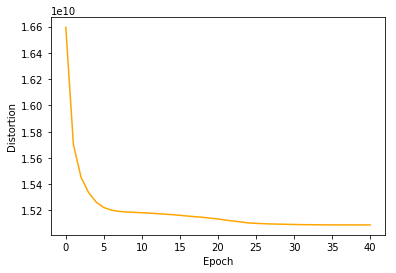

In [130]:
plt.plot(filip_km.get_distortion(),color='orange')
plt.xlabel('Epoch')
plt.ylabel('Distortion')

plt.show()